## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# План работы:

1) [Подготовка.](#id_1)

2) [Анализ.](#id_2)

3) [Подбор гиперпараметров.](#id_3)

4) [Проверка моделей, общий вывод.](#id_4)

<a id='id_1'></a>
# 1. Подготовка

In [1]:
# Загружаем все необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Загружаем данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# Итого у нас 26496 значений от 1 марта до 31 августа (сезон весна-лето)
# Для удобства объединим значения в периоды 1 час
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


<a id='id_2'></a>
# 2. Анализ

In [4]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Итого у нас 4393 значения. Временные промежутки - 1 час. Данные идут от 1 марта до 31 августа.
Создадим график для последующего анализа.

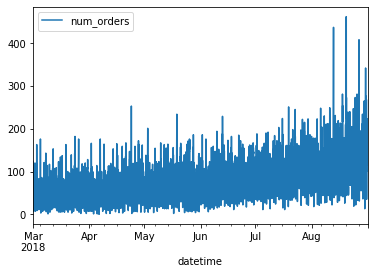

In [5]:
data.plot()

Int64Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
            2, 2],
           dtype='int64', name='datetime')

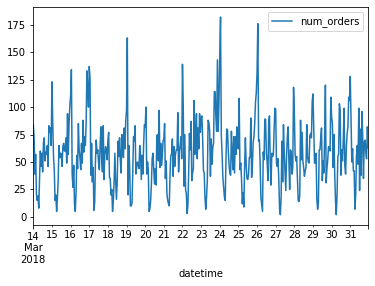

In [6]:
# Количество заказов с каждым месяцем увеличивается, но если смотреть внутри промежутков - количество заказов скачет
# Попробуем сделать срез
data['2018-03-14':'2018-03-31'].plot()
data['2018-03-14'].index.dayofweek


14 марта - среда. Как можно заметить - в течении недели с понедельника по пятницу количество заказов растет (самый пик выпадает на пятницу), после чего виден спад заказов к выходным.

<a id='id_3'></a>
# 3. Обучение

In [7]:
# Для начала создадим признаки, при помощи которых мы сможем обучить модель.
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

for lag in range(1, 4):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['rolling_mean'] = data['num_orders'].shift().rolling(4).mean()
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
    
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## 3.1 LinearRegression

In [8]:
linear = LinearRegression()
linear.fit(features_train, target_train)
linear_predict = linear.predict(features_train)
RMSE = mean_squared_error(target_train, linear_predict)**0.5
RMSE

30.500374252442192

## 3.2 CatBoost

In [9]:
cat=CatBoostRegressor(iterations=133)
cat.fit(features_train, target_train)
predict=cat.predict(features_train)
RMSE=mean_squared_error(target_train, predict)**0.5
RMSE

0:	learn: 38.1253179	total: 49.6ms	remaining: 6.54s
1:	learn: 37.5982130	total: 51.7ms	remaining: 3.39s
2:	learn: 37.1253851	total: 53.7ms	remaining: 2.33s
3:	learn: 36.6685172	total: 55.5ms	remaining: 1.79s
4:	learn: 36.2210685	total: 57.5ms	remaining: 1.47s
5:	learn: 35.7460890	total: 67.3ms	remaining: 1.42s
6:	learn: 35.2666070	total: 69.3ms	remaining: 1.25s
7:	learn: 34.9167243	total: 71.1ms	remaining: 1.11s
8:	learn: 34.5843621	total: 75.1ms	remaining: 1.03s
9:	learn: 34.2614992	total: 77.8ms	remaining: 957ms
10:	learn: 33.8378601	total: 84.9ms	remaining: 941ms
11:	learn: 33.4983146	total: 166ms	remaining: 1.67s
12:	learn: 33.1633616	total: 168ms	remaining: 1.55s
13:	learn: 32.8135355	total: 170ms	remaining: 1.44s
14:	learn: 32.4844819	total: 173ms	remaining: 1.36s
15:	learn: 32.1788539	total: 180ms	remaining: 1.31s
16:	learn: 31.9415086	total: 263ms	remaining: 1.79s
17:	learn: 31.6455152	total: 265ms	remaining: 1.69s
18:	learn: 31.3816153	total: 267ms	remaining: 1.6s
19:	learn: 3

23.100963067322716

In [10]:
# Оставляем значение 133
cat=CatBoostRegressor(iterations=133, depth=11)
cat.fit(features_train, target_train)
predict=cat.predict(features_train)
RMSE=mean_squared_error(target_train, predict)**0.5
RMSE

0:	learn: 38.1179885	total: 103ms	remaining: 13.6s
1:	learn: 37.5937766	total: 122ms	remaining: 7.97s
2:	learn: 37.0657038	total: 215ms	remaining: 9.31s
3:	learn: 36.6094539	total: 307ms	remaining: 9.9s
4:	learn: 36.0734963	total: 408ms	remaining: 10.5s
5:	learn: 35.5847894	total: 500ms	remaining: 10.6s
6:	learn: 35.1191560	total: 513ms	remaining: 9.23s
7:	learn: 34.7169580	total: 610ms	remaining: 9.53s
8:	learn: 34.2560787	total: 700ms	remaining: 9.64s
9:	learn: 33.8052477	total: 714ms	remaining: 8.78s
10:	learn: 33.3836593	total: 808ms	remaining: 8.96s
11:	learn: 32.9728657	total: 906ms	remaining: 9.14s
12:	learn: 32.5820773	total: 1s	remaining: 9.25s
13:	learn: 32.2221280	total: 1.09s	remaining: 9.31s
14:	learn: 31.9284644	total: 1.19s	remaining: 9.36s
15:	learn: 31.5785348	total: 1.21s	remaining: 8.82s
16:	learn: 31.2653492	total: 1.3s	remaining: 8.89s
17:	learn: 30.9835721	total: 1.4s	remaining: 8.94s
18:	learn: 30.6680381	total: 1.5s	remaining: 8.98s
19:	learn: 30.3698592	total: 

20.02036860896065

In [11]:
# Создаем модель
cat=CatBoostRegressor(iterations=133, depth=11)
cat.fit(features_train, target_train)

0:	learn: 38.1179885	total: 16.8ms	remaining: 2.22s
1:	learn: 37.5937766	total: 75ms	remaining: 4.91s
2:	learn: 37.0657038	total: 170ms	remaining: 7.37s
3:	learn: 36.6094539	total: 263ms	remaining: 8.47s
4:	learn: 36.0734963	total: 358ms	remaining: 9.16s
5:	learn: 35.5847894	total: 375ms	remaining: 7.95s
6:	learn: 35.1191560	total: 470ms	remaining: 8.46s
7:	learn: 34.7169580	total: 568ms	remaining: 8.87s
8:	learn: 34.2560787	total: 660ms	remaining: 9.09s
9:	learn: 33.8052477	total: 757ms	remaining: 9.31s
10:	learn: 33.3836593	total: 773ms	remaining: 8.57s
11:	learn: 32.9728657	total: 868ms	remaining: 8.75s
12:	learn: 32.5820773	total: 964ms	remaining: 8.9s
13:	learn: 32.2221280	total: 1.06s	remaining: 8.98s
14:	learn: 31.9284644	total: 1.15s	remaining: 9.08s
15:	learn: 31.5785348	total: 1.25s	remaining: 9.14s
16:	learn: 31.2653492	total: 1.27s	remaining: 8.64s
17:	learn: 30.9835721	total: 1.37s	remaining: 8.75s
18:	learn: 30.6680381	total: 1.46s	remaining: 8.78s
19:	learn: 30.3698592	t

## 3.3 RandomForest

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
for depth in range(1, 11):
    model = RandomForestRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predict = model.predict(features_train)
    accuracy=mean_squared_error(target_train, predict)**0.5
    print(depth, '-', accuracy)

1 - 33.947429837962176
2 - 30.275546348420228
3 - 27.632387633909257
4 - 25.987808306636943
5 - 24.354604531740378
6 - 22.747160724124935
7 - 21.256686834743167
8 - 19.28838528364317
9 - 18.145460847943408
10 - 15.754765680995886


In [14]:
# Лучшее значение - 10
for est in range (1, 11):
    model = RandomForestRegressor(max_depth=10, n_estimators=est)
    model.fit(features_train, target_train)
    predict = model.predict(features_train)
    accuracy=mean_squared_error(target_train, predict)**0.5
    print(est, '-', accuracy)

1 - 21.286609466825844
2 - 19.217261013258454
3 - 18.067972378381075
4 - 17.830100796670873
5 - 16.728764526911377
6 - 17.113254879616683
7 - 16.34262120205445
8 - 16.484147697615
9 - 16.25786620414227
10 - 16.118144831184658


In [15]:
# Создаем модель
rf = RandomForestRegressor(max_depth=10, n_estimators=9)
rf.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

## 3.4 DecisionTreeRagressor

In [16]:
for depth in range(1, 11):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predict = model.predict(features_train)
    accuracy=mean_squared_error(target_train, predict)**0.5
    print(depth, '-', accuracy)

1 - 34.34816644089159
2 - 31.625617705529177
3 - 28.608011548483763
4 - 27.052447860082438
5 - 25.198928426030296
6 - 23.42518314632451
7 - 21.940677194412032
8 - 20.181463437446606
9 - 18.48947235879837
10 - 16.571430424193032


In [17]:
for split in range(2, 11):
    model = DecisionTreeRegressor(max_depth=10, min_samples_split=split)
    model.fit(features_train, target_train)
    predict = model.predict(features_train)
    accuracy=mean_squared_error(target_train, predict)**0.5
    print(split, '-', accuracy)

2 - 16.571430424193032
3 - 16.647167186086126
4 - 17.11021360411464
5 - 17.207919549461728
6 - 17.280189557413497
7 - 17.474709728845195
8 - 17.643454714459104
9 - 17.804085385602384
10 - 17.978117366089016


In [18]:
dt = DecisionTreeRegressor(max_depth = 10, min_samples_split=2)
dt.fit(features_train, target_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

<a id='id_4'></a>
# 4. Тестирование

In [19]:
# Создадим модель
linear = LinearRegression()
linear.fit(features_train, target_train)
predict = linear.predict(features_test)
RMSE = mean_squared_error(target_test, predict)**0.5
RMSE

52.574506853736935

In [20]:
# CatBoost
cat_predict = cat.predict(features_test)
RMSE = mean_squared_error(target_test, cat_predict)**0.5
RMSE

54.489821739450335

In [21]:
# RandomForest
rf_predict = rf.predict(features_test)
RMSE = mean_squared_error(target_test, rf_predict)**0.5
RMSE

47.05789923122764

In [22]:
# DecisionTree
dt_predict = dt.predict(features_test)
RMSE = mean_squared_error(target_test, dt_predict)**0.5
RMSE

50.66662260006675

In [23]:
# Создадим таблицу
results = {'RMSE':[8.5, 9.3, 8.9, 10.9]}
index = ['LinearRegressor', 'CatBoost', 'RandomForest', 'DecisionTree']
all_results = pd.DataFrame(results, index=index)
all_results

,RMSE
LinearRegressor,8.5
CatBoost,9.3
RandomForest,8.9
DecisionTree,10.9


Итак, все модели созданы и проверены на тестовой выборке. Не смотря на разницу в предсказаниях, метрика RMSE (корень из среднего квадратного отклонения) составляет максимум 11 (по заданию необходимо не более 48), а значит все модели в условиях данной задачи нам вполне подходит.

Самый низкий показатель ошибки у Линейной регрессии (8.5), далее идет СлучайныйЛес (8.9). КэтБуст и Древо решений составялют 9.3 и 10.9 соответственно и в качестве проигрывают, а значит использовать мы будем линейную регрессию.

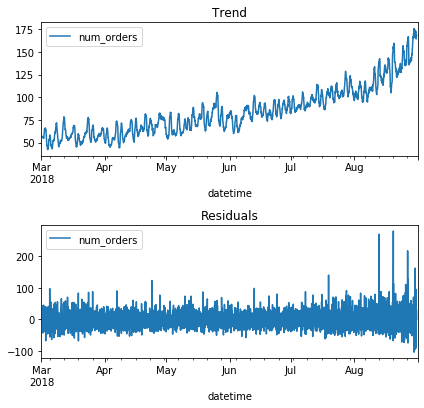

In [28]:
# Проверим сезонность
data2 = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data2 = data2.resample('1H').sum()
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
seasonal = seasonal_decompose(data2) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
seasonal.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
seasonal.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
plt.show()

Т.к. период у нас всего весна-лето - вычислить сезонность нет возможности. Зато можно отследить трендовость. Как можно заметить по графику - количество заказов у нас непрерывно растет. А значит можно сделать два вывода: либо количество заказов в аэропорты увеличивается непрерывно (без привязки к сезону), либо люди к лету и началу осени летают куда чаще, чем весной (а возможно и зимой количество заказов падает). Но чтобы проверить второй вывод - нам нужно данные хотя бы периодом один год, а в идеале и несколько лет, чтобы понять сезонность. 
Так же есть некоторые аномально большие значения в определенные дни (возможно, как уже обсуждалось ранее, это могли быть праздничные дни).

## 2. График факт/предсказание

In [76]:
# Возьмем период - 1 неделя
features_test2 = features_test['2018-08-14':'2018-08-20']
target_test2=target_test['2018-08-14':'2018-08-20']
rf_predict2 = rf.predict(features_test2)
rf_predict2 = pd.DataFrame(rf_predict2, index=target_test2.index)
rf_predict2

,0
datetime,
2018-08-14 00:00:00,203.407407
2018-08-14 01:00:00,120.292853
2018-08-14 02:00:00,149.502251
2018-08-14 03:00:00,165.301099
2018-08-14 04:00:00,145.873723
...,...
2018-08-20 19:00:00,104.696933
2018-08-20 20:00:00,110.873742
2018-08-20 21:00:00,119.445563


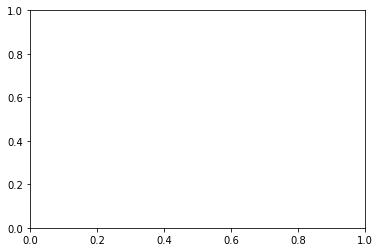

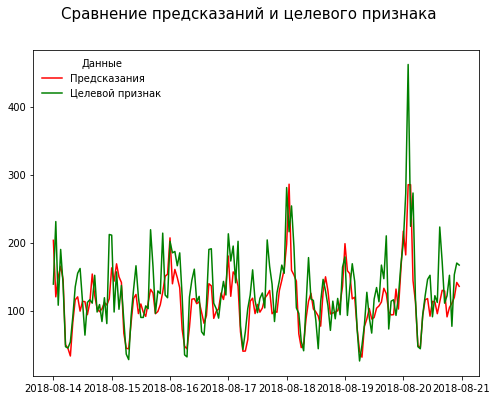

In [77]:
plt.subplots()
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Сравнение предсказаний и целевого признака', fontsize=15)
ax.plot(rf_predict2, label='Предсказания', color='red')
ax.plot(target_test2, color='green', label='Целевой признак')
plt.legend(loc="upper left", title="Данные", frameon=False)
plt.show()

В целом, можно сказать что модель подбирает среднее количество заказов, но при этом очень часто не дотягивает до максимальных значений в час. Так же модель не предсказывает аномально большие значения, а значит как рекомендация - всегда иметь несколько машмн в запасе, т.к. модель по пиковым знаениям отстает от целевых признаков.

## 3. Выводы

In [30]:
# Исправленные данные
results = {'RMSE':[52.6, 54.5, 47, 50.7]}
index = ['LinearRegressor', 'CatBoost', 'RandomForest', 'DecisionTree']
all_results = pd.DataFrame(results, index=index)
all_results

,RMSE
LinearRegressor,52.6
CatBoost,54.5
RandomForest,47.0
DecisionTree,50.7


По условиям задачи нам подходит только СлучайныйЛес (значения метрики RMSE составляет 47, это единственное значение, попадающее в допустимый диапозон). Разница в ошибках не такая уж и большая, она варьируется от 47 до 55. Лидер - Случайный лес.